In [1]:
import pandas as pd
import numpy as np
import json
import re
from plotnine import *
import plotnine


%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (15,8)


# pandas max row 
pd.options.display.max_rows = 3000

# 데이터셋팅

- 전유부(호별 정보)와 아파트 매매 정보 PNU 코드로 통일(매매 정보 기준)
- 매매 정보 : 계약 정보 기준으로 입력 >> 작성 기준 현재 정보
- 전유부 : 첫 데이터 작성 이후 주소 누락 및 아파트 명 변경으로 인한 현재 정보와의 불일치 확인

## 1. 전유부

- PNU 코드 추가
- apt 추출
- 건물별 면적, 층별 세대로 그룹화

### 1.1 전유부 데이터 전처리

- PNU 코드 추가
- apt 추출(용도 기준, 면적 기준으로 분리)

In [2]:
# 전유부 데이터
b_unit = pd.read_csv('data/전유부.csv', dtype={
    '건물명':object, 
    '시군구코드': object, 
    '법정동코드' : object, 
    '층번호': np.int64, 
    '번' : object, 
    '지' : object, 
    '층구분코드': object 
    }
)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
# 전유부 데이터 PNU 추가
b_unit['건물명'] = b_unit['건물명'].str.replace(' ','')
b_unit['번'] = b_unit['번'].astype(str).str.zfill(4)
b_unit['지'] = b_unit['지'].astype(str).str.zfill(4)

b_unit['동'] = b_unit['대지주소'].str.replace('세종특별자치시 ',"") # 동이름으로 입력(리 단위 무시)
b_unit['동'] = b_unit['동'].str.split(' ').str[1]
b_unit['지번'] = b_unit['번'] + b_unit['지']
b_unit['PNU'] = b_unit['동'] + b_unit['번'] + b_unit['지']
b_unit.tail()

,대지주소,시군구코드,법정동코드,동명칭,호명칭,층구분코드,층번호,면적(전용면적),건물명,번,지,용도코드명,주용도코드,기타용도,동,지번,PNU
998857,세종특별자치시 소정면 대곡리 467번지,36110,39023,NaN,301호,20,3,5.40,NaN,0467,0000,NaN,NaN,NaN,소정면,04670000,소정면04670000
998858,세종특별자치시 소정면 대곡리 467번지,36110,39023,NaN,201호,20,2,53.34,NaN,0467,0000,다세대주택,2003,다세대주택,소정면,04670000,소정면04670000
998859,세종특별자치시 소정면 대곡리 467번지,36110,39023,NaN,201호,20,2,5.40,NaN,0467,0000,NaN,NaN,NaN,소정면,04670000,소정면04670000
998860,세종특별자치시 소정면 대곡리 467번지,36110,39023,NaN,203호,20,2,50.10,NaN,0467,0000,다세대주택,2003,다세대주택,소정면,04670000,소정면04670000
998861,세종특별자치시 소정면 대곡리 467번지,36110,39023,NaN,203호,20,2,10.80,NaN,0467,0000,NaN,NaN,NaN,소정면,04670000,소정면04670000


<AxesSubplot:>

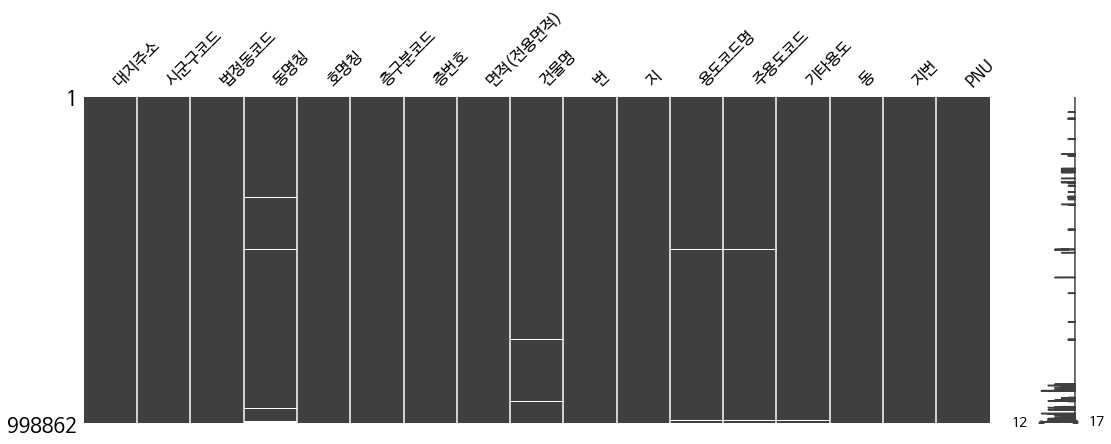

In [4]:
# 결측치 보기
import missingno as msno
msno.matrix(b_unit, figsize=(18,6))

In [5]:
#주용도 == 아파트
apt_unit = b_unit[b_unit['용도코드명'] == '아파트']

In [6]:
#아파트의 기타용도
apt = ['아파트','주택', '도시형']
pattern = '|'.join(apt)
apt_unit = apt_unit[apt_unit['기타용도'].str.contains(pattern,na=False)]
apt_unit['기타용도'].unique()

array(['공동주택(도시형생활주택)', '도시형생활주택(계단실,복도등)', '도시형생활주택(기계,전기실)',
       '도시형생활주택(주차장)', '아파트', '도시형생활주택(원룸형주택)', '공동주택(아파트)', '아파트 지하계단실',
       '(도시형생활주택 원룸형)', '아파트(도시형생활주택)', '도시형생활주택', '공동주택(도시형생활주택-원룸형)',
       '공동주택(도시형생활주택(원룸형))', '아파트(도시형생활주택-원룸형)', '공둥주택(아파트)', '주택',
       '도시형생활주택(펌프실)', '도시형생활주택(관리사무실)', '도시형생활주택(계단실,복도,벽체)', '연립주택',
       '도시형생활주택(원룸형)', '사원아파트', '공동주택(노인정)', '공동주택(전기실,관리사무소)',
       '공동주택(테니스락커룸)', '공동주택(경비실)', '공동주택(지하저수조)', '공동주택(오수처리장)',
       '노인정(아파트)', '아파트상가'], dtype=object)

In [7]:
#아파트 비해당 정보 제외
non_apt = ['지하','주차장','상가','노인정','사원아파트','계단', '전기','펌프', '경비','테니스','처리장','관리']
pattern = '|'.join(non_apt)
apt_unit = apt_unit.loc[~apt_unit['기타용도'].str.contains(pattern, case = False)]
apt_unit['기타용도'].unique()

array(['공동주택(도시형생활주택)', '아파트', '도시형생활주택(원룸형주택)', '공동주택(아파트)',
       '(도시형생활주택 원룸형)', '아파트(도시형생활주택)', '도시형생활주택', '공동주택(도시형생활주택-원룸형)',
       '공동주택(도시형생활주택(원룸형))', '아파트(도시형생활주택-원룸형)', '공둥주택(아파트)', '주택',
       '연립주택', '도시형생활주택(원룸형)'], dtype=object)

In [8]:
# 행정규칙 기준 최소주거기준 14m2 기준 이하 해당 부분 제거
print('최소주거기준 미달 : ', apt_unit[apt_unit['면적(전용면적)'] <= 14]['면적(전용면적)'].unique())
apt_unit = apt_unit[apt_unit['면적(전용면적)'] >= 14]


최소주거기준 미달 :  [12.822   5.1    11.41   10.8603  7.13   12.5154  9.0919 10.5804 10.6042
 10.835  12.1799  8.9186 13.0046  9.5964  9.3626 12.3598  9.2858 12.2221
 13.466  13.4319 13.4633 11.7236 10.9379 11.2752  8.4628  9.4529  8.53
  8.256  12.67    8.087  13.933   9.181   8.917   9.45  ]


### 1.2 아파트 층별 분리
- 아파트별 층별 카테고리 부여

(array([0.00896861, 0.00896861, 0.00896861, 0.01345291, 0.02242152,
        0.06726457, 0.11659193, 0.13004484, 0.24663677, 0.2690583 ,
        0.29147982, 0.29147982, 0.30941704, 0.30941704, 0.32286996,
        0.41255605, 0.41255605, 0.4529148 , 0.52914798, 0.5470852 ,
        0.58295964, 0.60089686, 0.6367713 , 0.64125561, 0.64573991,
        0.69955157, 0.71748879, 0.73542601, 0.75784753, 0.93273543,
        0.97757848, 0.97757848, 0.97757848, 0.97757848, 0.98206278,
        0.98654709, 0.98654709, 0.99103139, 0.99103139, 0.99103139,
        0.99103139, 0.99103139, 0.99103139, 0.99103139, 0.99103139,
        0.99103139, 0.99103139, 1.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <BarContainer object of 48 artists>)

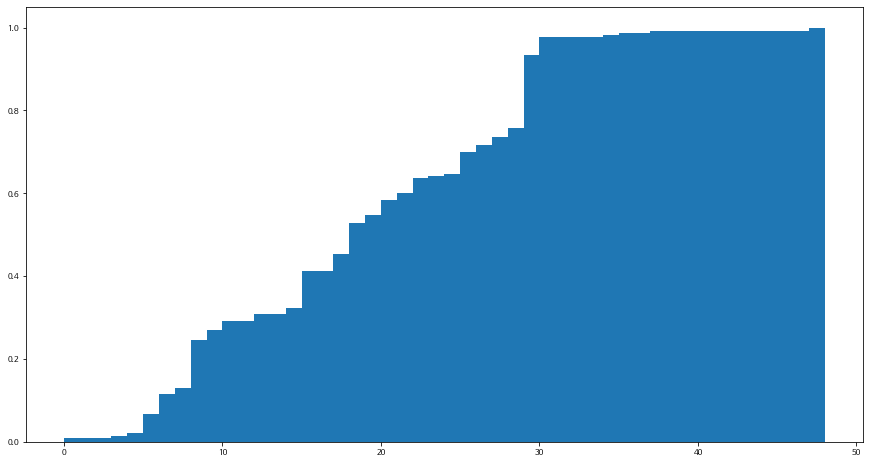

In [9]:
apt_floor = apt_unit.groupby('대지주소').agg({'층번호' : 'max'})

binwidth = 1
plt.hist(apt_floor['층번호'], bins=np.arange(min(apt_floor['층번호']), max(apt_floor['층번호']) + binwidth, binwidth), density=True, cumulative = True)

In [10]:
bins = [0,10,19,29]
apt_floor_new = apt_floor.reset_index()
apt_floor_new['층'] = np.digitize(apt_floor_new['층번호'], bins)
display(apt_floor_new.groupby('층').agg('count'))
apt_new = pd.merge(apt_unit,apt_floor_new,on='대지주소')
apt_new.head()

,대지주소,층번호
층,,
1,60,60
2,58,58
3,51,51
4,54,54


,대지주소,시군구코드,법정동코드,동명칭,호명칭,층구분코드,층번호_x,면적(전용면적),건물명,번,지,용도코드명,주용도코드,기타용도,동,지번,PNU,층번호_y,층
0,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,301,20,3,26.2699,세종펠리스,4121,1002,아파트,2001,공동주택(도시형생활주택),반곡동,41211002,반곡동41211002,6,1
1,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,302,20,3,26.2699,세종펠리스,4121,1002,아파트,2001,공동주택(도시형생활주택),반곡동,41211002,반곡동41211002,6,1
2,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,303,20,3,26.2699,세종펠리스,4121,1002,아파트,2001,공동주택(도시형생활주택),반곡동,41211002,반곡동41211002,6,1
3,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,304,20,3,24.4099,세종펠리스,4121,1002,아파트,2001,공동주택(도시형생활주택),반곡동,41211002,반곡동41211002,6,1
4,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,305,20,3,24.4099,세종펠리스,4121,1002,아파트,2001,공동주택(도시형생활주택),반곡동,41211002,반곡동41211002,6,1


### 1.3 건물, 면적으로 groupping

In [13]:
#건물별 면적으로 groupping
apt_new['면적(전용면적)'] = np.trunc(apt_new['면적(전용면적)']).astype(float)
apt_group = apt_new.groupby(['대지주소','면적(전용면적)']).agg({'동명칭' : 'count','건물명' : 'first','PNU' : 'first','지번' : 'first','법정동코드' : 'first','층' : 'max', '동' : 'first'})
apt_group = apt_group.reset_index(level=[0,1])

apt_group.head()

,대지주소,면적(전용면적),동명칭,건물명,PNU,지번,법정동코드,층,동
0,세종특별자치시 고운동 1386번지,59.0,508,가락마을17단지,고운동13860000,13860000,11200,2,고운동
1,세종특별자치시 고운동 1387번지,84.0,263,가락마을22단지,고운동13870000,13870000,11200,3,고운동
2,세종특별자치시 고운동 1387번지,96.0,177,가락마을22단지,고운동13870000,13870000,11200,3,고운동
3,세종특별자치시 고운동 1390번지,84.0,268,가락마을21단지,고운동13900000,13900000,11200,3,고운동
4,세종특별자치시 고운동 1390번지,99.0,138,가락마을21단지,고운동13900000,13900000,11200,3,고운동


In [14]:
# 건물명 없는 주소지
apt_group[apt_group['건물명'].isnull()]['대지주소'].unique()

array(['세종특별자치시  조치원읍 번암리 66-14번지', '세종특별자치시  조치원읍 상리 79-3번지',
       '세종특별자치시  조치원읍 서창리 177-22번지', '세종특별자치시  조치원읍 정리 105-14번지',
       '세종특별자치시  조치원읍 정리 59-1번지', '세종특별자치시  조치원읍 죽림리 208-2번지',
       '세종특별자치시  조치원읍 죽림리 389번지'], dtype=object)

In [15]:
apt_group.groupby('층').agg({'대지주소' : 'count'})

,대지주소
층,
1,237
2,193
3,222
4,211


## 2. apt 실거래 자료

- 전처리
- PNU 코드 추가


In [16]:
# 실거래 데이터
apt_trd = pd.read_csv('data/apt_trd.csv')
apt_trd['거래금액'] = apt_trd['거래금액'].str.replace(',','').astype(float)
apt_trd['아파트'] =apt_trd['아파트'].str.replace(' ','').astype(str)
apt_trd['전용면적'] = np.trunc(apt_trd['전용면적'])

apt_trd['월'] = apt_trd['월'].astype(str).str.zfill(2)
apt_trd['일'] = apt_trd['일'].astype(str).str.zfill(2)

apt_trd['계약일자'] = apt_trd['년'].astype(str) + apt_trd['월'] + apt_trd['일']
apt_trd['계약일자'] = pd.to_datetime(apt_trd['계약일자'], format='%Y%m%d')

apt_trd.head()

,Unnamed: 0,거래금액,건축년도,년,법정동,아파트,월,일,전용면적,지번,지역코드,층,해제사유발생일,해제여부,계약일자
0,0,36400.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,10,84.0,521,36110,5,NaN,NaN,2017-01-10
1,1,39282.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,20,84.0,521,36110,24,NaN,NaN,2017-01-20
2,2,49000.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,21,97.0,BL-M3,36110,13,NaN,NaN,2017-01-21
3,3,40800.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,25,97.0,BL-M3,36110,7,NaN,NaN,2017-01-25
4,4,8600.0,2016,2017,보람동,스타힐타워Ⅰ,01,01,16.0,743,36110,7,NaN,NaN,2017-01-01


In [17]:
# 지번 아닌 값 찾기
apt_trd['지번'].unique()

array(['521', 'BL-M3', '743', '947', '974', '939', '971', '976', '714',
       '750', '712', '759', '732', '649', '603', '548', '683', '690',
       '652', '656', '654', '679', '640', '1706', '1393', '1400', '1386',
       '1390', '1395', '1408', '1708', '1401', '1284', '1277', '1282',
       '1356', '1339', '1276', '1297', '858', '627', '633', '853', '681',
       '664', '855', '859', '666', '685', '456', '89', '398', '399',
       '393', '396', '72', '92', '75-2', '542', '35-3', '244-1', '133-10',
       '255', '970-3', '976-2', '401-48', '263', '320', '259-1', '268',
       '622', '197-16', '586', '715', '751', '775', '613', '697', '1703',
       '1705', '1409', '1279', '641', '636', '638', '651', '12-1', '11-1',
       '140', '167', '21-2', '389', '213-28', '528', '713', '763', '748',
       '845', '498-7', '121-6', '35-1', '739', '1396', '639', '346',
       '598', '700-1', '1387', '121', '605', '561', '593', '614', '558',
       '744', '653', '777', '764', '599', '597', '611', '3

In [18]:
# BL값, 가- 번지로 교체
apt_trd['지번'] = apt_trd['지번'].replace('BL-M3', 550)
apt_trd['지번'] = apt_trd['지번'].replace('BL H1', 738)
apt_trd['지번'] = apt_trd['지번'].replace('가-4102-1', '35-5')
apt_trd['지번'] = apt_trd['지번'].replace('가-4102-3', '59-7')
apt_trd['지번'] = apt_trd['지번'].replace('가-4101-2', '393-1')
apt_trd['지번'] = apt_trd['지번'].replace('가-4101-4', '143-1')
apt_trd['지번'] = apt_trd['지번'].replace('가-4121-2002', '771-87')
apt_trd['지번'] = apt_trd['지번'].replace('가-', 946)

In [19]:
#PNU코드 생성
apt_trd['번'] = apt_trd['지번'].astype(str).str.split('-').str[0]
apt_trd['지'] = apt_trd['지번'].astype(str).str.split('-').str[1]
apt_trd['번'] = apt_trd['번'].fillna(0)
apt_trd['지'] = apt_trd['지'].fillna(0)
apt_trd['번'] = apt_trd['번'].astype(str).str.zfill(4)
apt_trd['지'] = apt_trd['지'].astype(str).str.zfill(4)
apt_trd['법정동'] = apt_trd['법정동'].str.split(' ').str[0]
apt_trd['PNU'] = apt_trd['법정동'].astype(str) + apt_trd['번'] + apt_trd['지']
apt_trd.tail()

,Unnamed: 0,거래금액,건축년도,년,법정동,아파트,월,일,전용면적,지번,지역코드,층,해제사유발생일,해제여부,계약일자,번,지,PNU
24412,24412,7000.0,2001,2021,전의면,민석그린,02,18,59.0,528,36110,5,NaN,NaN,2021-02-18,0528,0000,전의면05280000
24413,24413,5200.0,1994,2021,전동면,도원,02,03,49.0,586,36110,5,NaN,NaN,2021-02-03,0586,0000,전동면05860000
24414,24414,5200.0,1994,2021,전동면,도원,02,23,49.0,586,36110,5,NaN,NaN,2021-02-23,0586,0000,전동면05860000
24415,24415,5000.0,1996,2021,소정면,무궁화,02,01,59.0,35-1,36110,7,NaN,NaN,2021-02-01,0035,0001,소정면00350001
24416,24416,6300.0,1996,2021,소정면,무궁화,02,08,59.0,35-1,36110,7,NaN,NaN,2021-02-08,0035,0001,소정면00350001


## 3. Trd 데이터에 아파트 정보 추가
- 아파트 층/세대수
- (추가예정) 아파트 근린시설

In [68]:
samples = apt_trd[{'계약일자','거래금액','아파트','전용면적','PNU','번','지','층'}].copy()
samples.head()

,PNU,지,번,층,전용면적,거래금액,계약일자,아파트
0,소담동05210000,0000,0521,5,84.0,36400.0,2017-01-10,새샘마을9단지(중흥S클래스리버뷰)
1,소담동05210000,0000,0521,24,84.0,39282.0,2017-01-20,새샘마을9단지(중흥S클래스리버뷰)
2,소담동05500000,0000,0550,13,97.0,49000.0,2017-01-21,새샘마을3단지(모아미래도리버시티)
3,소담동05500000,0000,0550,7,97.0,40800.0,2017-01-25,새샘마을3단지(모아미래도리버시티)
4,보람동07430000,0000,0743,7,16.0,8600.0,2017-01-01,스타힐타워Ⅰ


- 새뜸마을 5단지, 11단지, 10단지, 1단지, 14단지 : 전유부 정보 없음
- 해들마을1단지, 수루배마을1단지 : 면적 정보 부족

In [71]:
apt_group[apt_group['층'] == 4]['건물명'].unique()

array(['가락마을16단지', '가락마을13단지', '가락마을11단지', '가락마을5단지', '가락마을6단지',
       '나릿재마을1단지', '가온마을3단지', '가온마을6단지', '가온마을1단지', '가온마을10단지',
       '세종지웰푸르지오', '가온마을7단지', '가온마을9단지', '가온마을4단지', '해들마을6단지', '해들마을5단지',
       '해들마을4단지', '해들마을2단지', '해들마을1단지', '도램마을5단지', '도램마을20단지', '도램마을11단지',
       '도램마을10단지', '도램마을9단지', '도램마을14단지', '도램마을15단지', '수루배마을4단지',
       '수루배마을3단지', '호려울마을10단지', '호려울마을3단지', '호려울마을7단지', '호려울마을8단지',
       '호려울마을1단지', '새뜸마을4단지', '새뜸마을12단지', '새샘마을8단지', '새샘마을7단지', '새샘마을3단지',
       '새샘마을9단지', '새샘마을2단지', '새샘마을6단지', '범지기마을10단지', '범지기마을9단지',
       '범지기마을3단지', '범지기마을1단지', '범지기마을4단지', '가재마을4단지', '가재마을7단지',
       '가재마을12단지', '가재마을5단지', '가재마을9단지', '첫마을아파트'], dtype=object)

In [79]:
apt_df = apt_group
nan_info = {'새뜸마을5단지(메이저시티)' : { '세대수' : [651, 280, 164], '층' : 4},
            '새뜸마을11단지(더샵힐스테이트)' : { '세대수' : [281, 149, 6, 2], '층' : 4},
            '새뜸마을10단지(더샵힐스테이트)': { '세대수' : [132, 667, 219, 7], '층' : 4},
            '새뜸마을1단지(메이저시티)' :  { '세대수' : [198, 219, 660 ], '층' : 4},
            '새뜸마을14단지(더샵힐스테이트)' : { '세대수' : [196, 106], '층' : 3}}

for i in nan_info.keys() :
    df = samples[samples['아파트'] == i]
    df = df[{'PNU','지','번','전용면적','아파트'}].drop_duplicates()
    df['지번'] = df['번'] + df['지']
    df['동'] = df['PNU'].str[:-8]
    df['동명칭'] = nan_info.get(i)['세대수']
    df['층'] = nan_info.get(i)['층']

    df = df[{'PNU','전용면적','아파트','지번','동','동명칭','층'}]
    df.columns = ['PNU', '지번','층', '면적(전용면적)', '동명칭', '건물명','아파트']
    
    apt_df = pd.concat([apt_df,df],ignore_index = True)

apt_df.tail()

,대지주소,면적(전용면적),동명칭,건물명,PNU,지번,법정동코드,층,동,아파트
874,NaN,101.0,198,새롬동,새롬동06010000,06010000,NaN,4,NaN,새뜸마을1단지(메이저시티)
875,NaN,120.0,219,새롬동,새롬동06010000,06010000,NaN,4,NaN,새뜸마을1단지(메이저시티)
876,NaN,84.0,660,새롬동,새롬동06010000,06010000,NaN,4,NaN,새뜸마을1단지(메이저시티)
877,NaN,98.0,196,새롬동,새롬동05630000,05630000,NaN,3,NaN,새뜸마을14단지(더샵힐스테이트)
878,NaN,107.0,106,새롬동,새롬동05630000,05630000,NaN,3,NaN,새뜸마을14단지(더샵힐스테이트)


In [81]:
#PNU기준으로 건물명 통일하기
PNU = apt_df.copy().drop_duplicates()
PNU = PNU.set_index('PNU')
PNU = PNU.transpose()

PNU = PNU.to_dict()

<ipython-input-81-ab61fdfa23d0>:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.


In [82]:
apt_floor = []
apt_num = []
for i in samples.index :
    pnu_value = samples['PNU'].iloc[i]
    bid = samples['아파트'].iloc[i].split('(')[0]
    bid = bid.replace('단지', '단지 ')
    bid = bid.split(' ')[0]
    size = samples['전용면적'].iloc[i]

    if pnu_value in PNU : 
        apt_floor.append(PNU.get(pnu_value)['층'])
        apt_num.append(PNU.get(pnu_value)['동명칭'])

    elif len(apt_df[apt_df['건물명'].str.contains(bid, na=False )]) != 0 :
        df = apt_df[apt_df['건물명'].str.contains(bid, na=False )].copy()
        floor = df[df['면적(전용면적)'] == size]['층'].iloc[0] if len(df[df['면적(전용면적)'] == size]['층']) != 0 else np.nan
        num = df[df['면적(전용면적)'] == size]['동명칭'].iloc[0] if np.isnan(floor) == False else np.nan
        apt_floor.append(floor)
        apt_num.append(num)

    else :
        apt_floor.append(np.nan)
        apt_num.append(np.nan)

samples['층구분'] = apt_floor
samples['세대수'] = apt_num
samples[samples['층구분'].isnull()]['아파트'].unique()

array(['해들마을1단지', '수루배마을1단지'], dtype=object)

In [87]:
# Nan값 처리
samples.loc[6613,'층구분' : '세대수'] = [4,3]
samples.loc[14010,'층구분' : '세대수'] = [4,4]

In [89]:
samples.to_csv('data/매매값_아파트정보.csv')

## 아파트 기타용도텍스트 카운팅

In [57]:
# 아파트 추출
apt_unit = b_unit[b_unit['용도코드명']=='아파트']

list_pur = apt_unit['기타용도'].str.split('(').str[0]
list_pur = list_pur.tolist()

list_pur01 = []
for i in list_pur:
    a = i.split(',')
    if len(a) == 1 :
        list_pur01.append(a[0])
    else :
        for i in range(len(a)) :
            list_pur01.append(a[i])


In [148]:
list_pur02 = pd.Series(list_pur01)
result = list_pur02.value_counts().head(20)
result

NameError: name 'list_pur01' is not defined